### <p style="text-align: right;"> &#9989; Andrew Koren</p>

# PHY480 Day 8

## In-class activity: Ordinary differential equations (ODE) continued, Runge-Kutta methods

In this in-class assignment we explore how to build numerical ODE solvers of higher order. The equation is of the standard form
$$
\frac{dy}{dx}=f(x,y).
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Revisiting the explicit Euler integrator for the harmonic oscillator

First consider the explicit Euler integration scheme that we considered before.

In [7]:
# integrate dy/dx = f(x,y) with a forward Euler scheme,
# y may be a vector
# Input:
# rhs -- the right-hand-side function f(x,y)
# y0 -- the initial value y(x0)=y0, it must be a NumPy array or a list
#       (even in the scalar case it must be defined as array or list with one element)
# x0 -- initial integration point on x
# xf -- final integration point on x (i.e. we are finding y(x) in [x0,xf] range)
# h -- step size for the Euler method
# args -- additional arguments (e.g. parameters) for f(x,y)
# Output:
# status -- =0 on success
# y -- the last point y(xf)
# xlist -- list of all x points during the integration
# ylist -- y(x) at the x points above
def integrate_ode_euler( rhs, y0, x0, xf, h, args=None ):
    
    # number of steps, may need one more if xf-x0 is not
    # an integer multiple of h
    n = int( ( xf - x0 ) / h )
    
    # initialization
    y = y0.copy()
    xlist = [ x0 ]
    ylist = [ y0.copy() ]
    h2 = h # step size may be different for the last step

    # loop (one step more)
    for i in range(n+1):

        # check on the last step
        if i==n:
            if np.abs( xf - x ) > h*1e-7: # we need an extra last step which is less than h
                h2 = xf - x
                x = xf
            else: # done -- the last point is exactly on the boundary xf
                break
        else: # normal iteration
            x = x0 + h*(i + 1)

        # handle functions with and without arguments
        if args==None:
            f = rhs( x, y )
        else:
            f = rhs( x, y, args )

        # forward Euler update
        y += f * h2

        # store y(x) at the evaluated points
        xlist.append( x )
        ylist.append( y.copy() )

    # normal return
    status = 0
    return status, y, xlist, ylist


Let us apply the Euler scheme to the harmonic oscillator problem that we discussed in class. The equations of motion are given by

$$
\frac{dr}{dt}=v,
$$

$$
\frac{dv}{dt}=-\omega^2r.
$$

The initial condition is $r(0)=r_0$, $v(0)=0$. To be consisent with our previous notation we label

$$
x=t,
$$

$$
y=\left(
\begin{array}{r}
r \\
v
\end{array}
\right).
$$


**Task 1.** Write down an analytic solution to this problem.

$$
r''(t) =  -\omega^2 r \\
r = a \sin(\omega t)  + b\cos(\omega t) \\
r(0) = r_0 = b \\
a = 0 \\
r = r_0\cos(\omega t)
$$

In [145]:
from numpy import cos, sin

def sho_exact(t, r0, omega): # v0 = 0
    return r0*cos(omega*t)

**Task 2.** Experiment with running the code below.

In [4]:
# write hand side function for the harmonic oscillator equation
# Input:
# x -- time, scalar
# y -- two-component vector packing r and v (in that order)
# omega -- oscillator frequency
# Output
# two-component right-hand-side of the equation
def rhs_ho( x, y, omega=1.0 ):
    
    r = y[0]
    v = y[1]
    
    return np.array( [v, -omega**2*r] )


In [8]:
# frequency -- multiple of pi
omega=2*np.pi

# integrate from 0 to xf
x0 = 0.
xf = 2.

# the initial condition r0=2, v=0
y0 = np.array( [ 2., 0. ] )

# step size
h = 0.01

status, y, xlist, ylist = integrate_ode_euler( rhs_ho, y0, x0, xf, h, args=(omega))


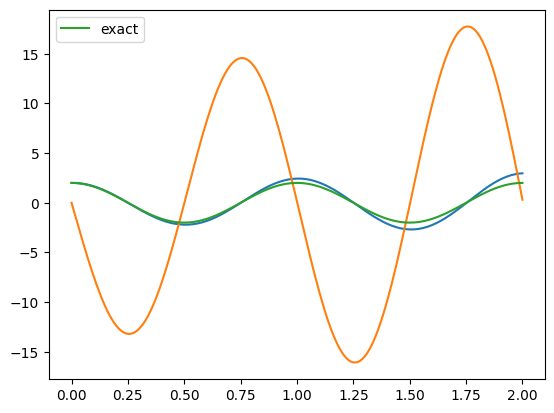

In [24]:
# plot r and v
plt.plot( xlist, ylist )
plt.plot(xlist, sho_exact(np.array(xlist), 2, omega), label='exact')
plt.legend();

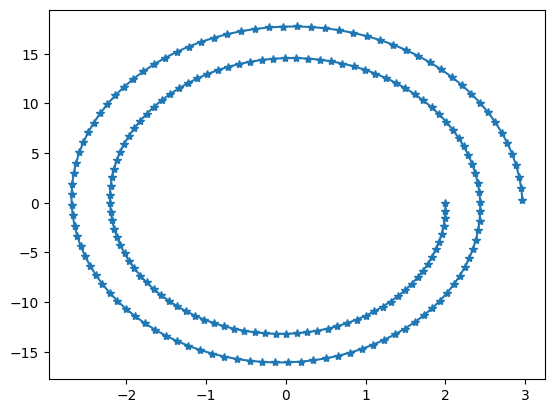

In [25]:
# plot the trajectory in the (r,v) phase space
A = np.array( ylist )
B = A.transpose()

plt.plot( B[0], B[1], "*-" )


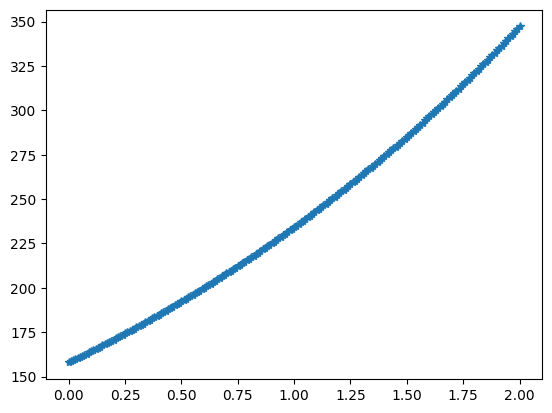

In [19]:
# check conservation of energy along the trajectory
energylist = []

for i in range(len(ylist)):
    
    r = ylist[i][0]
    v = ylist[i][1]
    energylist.append( v**2 + omega**2*r**2)
    
plt.plot(xlist,energylist,"*-")


## Runge-Kutta methods

Consider a Runge-Kutta method where the propagation from $y_x$ to $y_{x+h}$ happens in $s$ stages:

$$
y_i=y_x+h\sum_{j=1}^{i-1}a_{ij}k_j,
$$

$$
k_i=f(x+hc_i,y_i),
$$

$$
y_{x+h}=y_x+h\sum_{i=1}^{s}b_ik_i.
$$


Below there are four Runge-Kutta schemes: two of the second order, one of the third order and one of the fourth order. **NOTE:** the counting for the coefficients is 0-based, as usual in Python, while in our definition of the method it is 1-based. Thus, all indices are shifted down by one.

In [152]:
s = 2
a = np.zeros( (s,s) )
b = np.zeros( s )
c = np.zeros( s )

a[1,0] = 1/2
b[0] = 0
b[1] = 1
c[1] = 1/2

print(a,b,c)

[[0.  0. ]
 [0.5 0. ]] [0. 1.] [0.  0.5]


In [154]:
s = 2
a = np.zeros( (s,s) )
b = np.zeros( s )
c = np.zeros( s )

a[1,0] = 2/3
b[0] = 1/4
b[1] = 3/4
c[1] = 2/3

print(a,b,c)

[[0.         0.        ]
 [0.66666667 0.        ]] [0.25 0.75] [0.         0.66666667]


In [156]:
s = 3
a = np.zeros( (s,s) )
b = np.zeros( s )
c = np.zeros( s )

a[1,0] = 1/4
a[2,0] = -2/9
a[2,1] = 8/9
b[0] = 1/4
b[1] = 0
b[2] = 3/4
c[1] = 1/4
c[2] = 2/3

print(a,b,c)

[[ 0.          0.          0.        ]
 [ 0.25        0.          0.        ]
 [-0.22222222  0.88888889  0.        ]] [0.25 0.   0.75] [0.         0.25       0.66666667]


In [158]:
s = 4
a = np.zeros( (s,s) )
b = np.zeros( s )
c = np.zeros( s )

a[1,0] = 1/2
a[2,1] = 1/2
a[3,2] = 1
b[0] = 1/6
b[1] = 1/3
b[2] = 1/3
b[3] = 1/6
c[1] = 1/2
c[2] = 1/2
c[3] = 1

print(a,b,c)

[[0.  0.  0.  0. ]
 [0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  1.  0. ]] [0.16666667 0.33333333 0.33333333 0.16666667] [0.  0.5 0.5 1. ]


**Task 3.** Code the Runge-Kutta method in such a way that it can accept an arbitrary Butcher tableau (for an explicit method).


In [136]:
# Runge-Kutta integrator with a specified Butcher tableau
# Input:
# rhs -- the right-hand-side function f(x,y)
# y0 -- the initial value y(x0)=y0, it must be a NumPy array or a list
#       (even in the scalar case it must be defined as array or list with one element)
# x0 -- initial integration point on x
# xf -- final integration point on x (i.e. we are finding y(x) in [x0,xf] range)
# h -- step size
# s -- number of Runge-Kutta stages
# a,b,c -- Butcher tableau
# args -- additional arguments (e.g. parameters) for f(x,y)
# Output:
# status -- =0 on success
# y -- the last point y(xf)
# xlist -- list of all x points during the integration
# ylist -- y(x) at the x points above
def integrate_ode_rungekutta( rhs, y0:np.array, x0, xf, h, s, a, b, c, args=None):

    # set the dimension of the y vector
    nd = len(y0)
    
    # k_i storage
    kf = np.zeros( (s,nd) )
    
    # number of steps, may need one more if xf-x0 is not
    # an integer multiple of h
    nf = ( xf - x0 ) / h
    n = int(nf)

    # initialization
    xlist = [x0]
    ylist = [y0]
    status = 1
    
    y = y0.copy()

    # integration
    for step in range(n+1): #integration steps
        if step == n:
            if xlist[-1] == xf: # last step verification
                break
            else:
                h = xf - xlist[-1]

        for i in range(s): #rk steps
            yi = y + h * sum(a[i,j] * kf[j] for j in range(i)) 
            ki = rhs(xlist[-1]+h*c[i], yi, *args)
            y += h * b[i] * ki
        xlist.append(xlist[-1]+h)
        ylist.append(y.copy())

    if xlist[-1] == xf:
        status = 0   
    
    return status, y, xlist, ylist


**Task 4.** Rerun the harmonic oscillator case with different Runge-Kutta schemes (the four sets of coefficients given above).

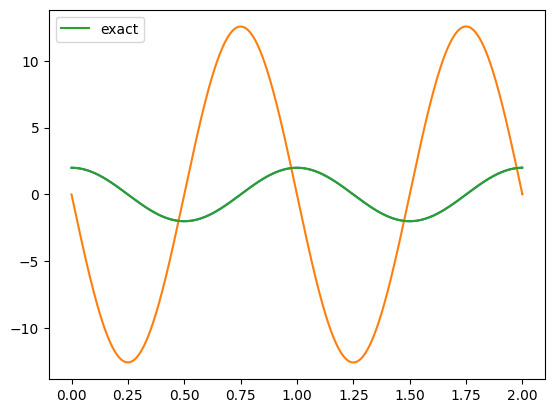

In [165]:
# frequency -- multiple of pi
omega=2*np.pi

# integrate from 0 to xf
x0 = 0.
xf = 2.

# the initial condition r0=2, v=0
y0 = np.array( [ 2., 0. ] )

# step size
h = 0.00005

status, y, xlist, ylist = integrate_ode_rungekutta( rhs_ho, y0, x0, xf, h, s, a, b, c, args=[omega])

plt.plot( xlist, ylist )
plt.plot(xlist, sho_exact(np.array(xlist), y0[0], omega), label='exact')
plt.legend();

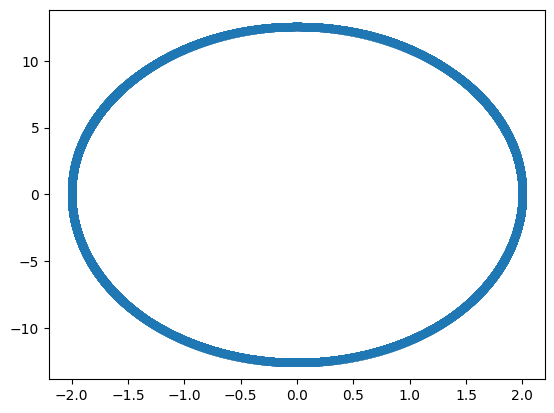

In [166]:
# plot the trajectory in the (r,v) phase space
A = np.array( ylist )
B = A.transpose()

plt.plot( B[0], B[1], "*-" )


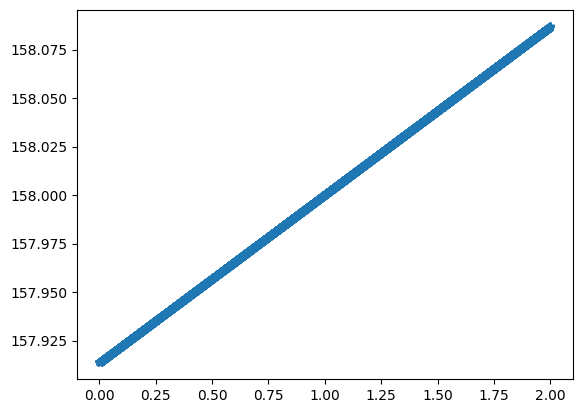

In [167]:
# check conservation of energy along the trajectory
energylist = []

for i in range(len(ylist)):
    
    r = ylist[i][0]
    v = ylist[i][1]
    energylist.append( v**2 + omega**2*r**2)
    
plt.plot(xlist,energylist,"*-")


**Task 5.** Make a plot of the distance between the numerical solution at the end of the trajectory (at `xf`) from the analytic solution at the same point versus the step size $h$ on a log-log scale. Experiment with the four different coefficient schemes given above and check that they scale as expected with the step size.

In [146]:
print(y0)

[2. 0.]


(10000, 1e-08)

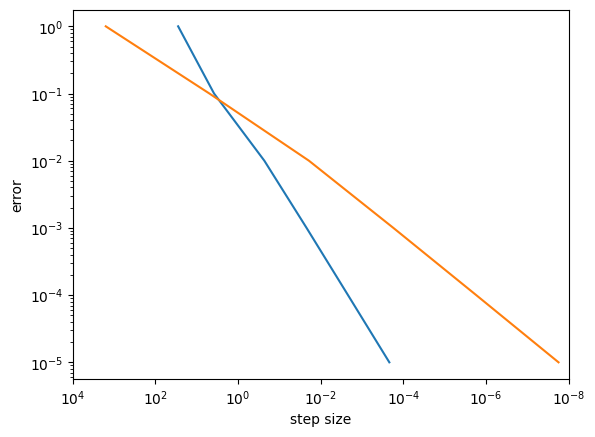

In [159]:
hlist = [10**-i for i in range(6)] #minutes below 10^-7
rf = sho_exact(xf, y0[0], omega)
vf = -2*omega*sin(omega*xf)

yf = (rf, vf)

results = []

for h in hlist:
    status, y, xlist, ylist = integrate_ode_rungekutta( rhs_ho, y0, x0, xf, h, s, a, b, c, args=[omega])
    assert status == 0
    results.append(abs(y-yf))

plt.plot(results, hlist)
plt.loglog()
plt.xlabel('step size')
plt.ylabel('error')
plt.xlim((10**4, 10**-8))

&#169; Copyright 2025,  Michigan State University Board of Trustees